In [1]:
import pandas as pd
import torch
import ltn
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')
from sklearn.preprocessing import StandardScaler

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### 1. Initial data analysis

In [2]:
file_path = 'Stud_E-mobility_data_staticLimit.csv'
data = pd.read_csv(file_path)
data_info = data.info()
data_head = data.head()
data_description = data.describe()
(data_info, data_head, data_description)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59442 entries, 0 to 59441
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   _time                       59442 non-null  object 
 1   GARAGE_EXTERNAL_POWER       59442 non-null  float64
 2   DEMAND_LIMIT                59442 non-null  float64
 3   DEMAND_LIMIT_INDICATOR      59442 non-null  float64
 4   BATTERY_SOC                 59442 non-null  float64
 5   BATTERY_DISCHARGE_POWER     59442 non-null  float64
 6   BATTERY_CHARGED_ENERGY      59442 non-null  float64
 7   BATTERY_DISCHARGED_ENERGY   59442 non-null  float64
 8   PV_POWER                    59442 non-null  float64
 9   PV_ENERGY                   59442 non-null  float64
 10  WALLBOX_ALPHA_ENERGY        59442 non-null  float64
 11  WALLBOX_ALPHA_POWER         59442 non-null  float64
 12  WALLBOX_1_ENERGY            59442 non-null  float64
 13  WALLBOX_1_POWER             594

(None,
                        _time  GARAGE_EXTERNAL_POWER  DEMAND_LIMIT  \
 0  2023-10-05 00:01:00+00:00               1.244171          50.0   
 1  2023-10-05 00:02:00+00:00               1.244171          50.0   
 2  2023-10-05 00:03:00+00:00               1.244171          50.0   
 3  2023-10-05 00:04:00+00:00               1.244171          50.0   
 4  2023-10-05 00:05:00+00:00               1.244171          50.0   
 
    DEMAND_LIMIT_INDICATOR  BATTERY_SOC  BATTERY_DISCHARGE_POWER  \
 0                     1.0         40.5                   -0.338   
 1                     1.0         40.5                   -0.372   
 2                     1.0         40.5                   -0.393   
 3                     1.0         40.5                   -0.339   
 4                     1.0         40.5                   -0.371   
 
    BATTERY_CHARGED_ENERGY  BATTERY_DISCHARGED_ENERGY  PV_POWER  PV_ENERGY  \
 0                     0.0                        0.0  0.008693        0.0   
 1   

### 2. Tourch NN

In [3]:

# Convert '_time' from string to datetime
data['_time'] = pd.to_datetime(data['_time'])

# Assume we're using all columns except '_time' and 'BATTERY_SOC' as features
features = data.drop(columns=['_time', 'BATTERY_SOC'])
targets = data['BATTERY_SOC']

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Convert to numpy arrays
features_numpy = np.array(features_scaled, dtype=np.float32)
targets_numpy = np.array(targets.values, dtype=np.float32).reshape(-1, 1)  # Reshape to make it a column vector

# Neural network model
class BatteryManagementModel(nn.Module):
    def __init__(self):
        super(BatteryManagementModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(features.shape[1], 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.layers(x)

model = BatteryManagementModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define accuracy for regression
def regression_accuracy(outputs, targets, threshold=5.0):
    correct = (torch.abs(outputs - targets) <= threshold).float()
    accuracy = correct.mean()
    return accuracy.item() * 100

# Manual batching
def manual_batching(data, batch_size):
    for i in range(0, len(data), batch_size):
        yield data[i:i + batch_size]

# Training function
def train(model, features, targets, batch_size=64, epochs=100):
    features_tensor = torch.tensor(features, dtype=torch.float32)
    targets_tensor = torch.tensor(targets, dtype=torch.float32)
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_accuracy = 0.0
        indices = np.arange(features_tensor.shape[0])
        np.random.shuffle(indices)
        for batch_indices in manual_batching(indices, batch_size):
            batch_features = features_tensor[batch_indices]
            batch_targets = targets_tensor[batch_indices]
            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_accuracy += regression_accuracy(outputs, batch_targets)
        average_loss = running_loss / (len(indices) / batch_size)
        average_accuracy = running_accuracy / (len(indices) / batch_size)
        print(f'Epoch {epoch + 1}/{epochs}, Accuracy: {average_accuracy:.2f}%')

# Testing function
def test(model, features, targets, batch_size=64):
    features_tensor = torch.tensor(features, dtype=torch.float32)
    targets_tensor = torch.tensor(targets, dtype=torch.float32)
    model.eval()
    total_loss = 0.0
    total_accuracy = 0.0
    count = 0
    with torch.no_grad():
        for batch_features, batch_targets in zip(manual_batching(features_tensor, batch_size), manual_batching(targets_tensor, batch_size)):
            outputs = model(batch_features)
            loss = criterion(outputs, batch_targets)
            total_loss += loss.item() * batch_features.size(0)
            total_accuracy += regression_accuracy(outputs, batch_targets)
            count += 1
    average_loss = total_loss / len(features)
    average_accuracy = total_accuracy / count
    print(f' Test Accuracy: {average_accuracy:.2f}%')

# Train and test the model
train(model, features_numpy, targets_numpy, batch_size=64, epochs=100)
test(model, features_numpy, targets_numpy, batch_size=64)


Epoch 1/100, Accuracy: 65.50%
Epoch 2/100, Accuracy: 82.19%
Epoch 3/100, Accuracy: 84.99%
Epoch 4/100, Accuracy: 85.91%
Epoch 5/100, Accuracy: 86.34%
Epoch 6/100, Accuracy: 86.67%
Epoch 7/100, Accuracy: 86.88%
Epoch 8/100, Accuracy: 87.08%
Epoch 9/100, Accuracy: 87.17%
Epoch 10/100, Accuracy: 87.55%
Epoch 11/100, Accuracy: 87.73%
Epoch 12/100, Accuracy: 87.96%
Epoch 13/100, Accuracy: 88.21%
Epoch 14/100, Accuracy: 88.28%
Epoch 15/100, Accuracy: 88.54%
Epoch 16/100, Accuracy: 88.78%
Epoch 17/100, Accuracy: 88.89%
Epoch 18/100, Accuracy: 88.94%
Epoch 19/100, Accuracy: 89.16%
Epoch 20/100, Accuracy: 89.23%
Epoch 21/100, Accuracy: 89.32%
Epoch 22/100, Accuracy: 89.42%
Epoch 23/100, Accuracy: 89.44%
Epoch 24/100, Accuracy: 89.55%
Epoch 25/100, Accuracy: 89.66%


KeyboardInterrupt: 

### 3. Rules satisfaction wirh LTN

### Our initial dataset and model with constraints

- 40% < SOC < 80%:
    - if GARAGE_EXTERNAL_POWER > DEMAND_LIMIT, e-cars charging power is covered by local battery.
- SOC < 40%:
    - if GARAGE_EXTERNAL_POWER > DEMAND_LIMIT, e-cars charging power is covered by local battery.
    - If GARAGE_EXTERNAL_POWER < DEMAND_LIMIT, local battery is charged from the grid.
- SOC < 15%: Battery discharging is stopped due to battery health

In [4]:
delta = 0.5 # Tolerance for the power limit
SOC_less_15 = data[(data["BATTERY_SOC"]<=15) & (data["BATTERY_DISCHARGE_POWER"]<=0)]
SOC_less_40_1 = data[(data["BATTERY_SOC"]>15) &(data["BATTERY_SOC"]<40) & (data["GARAGE_EXTERNAL_POWER"]<50) & (data["BATTERY_DISCHARGE_POWER"]<0)]
SOC_less_40_2 = data[(data["BATTERY_SOC"]>15) &(data["BATTERY_SOC"]<40) & (data["GARAGE_EXTERNAL_POWER"]<=(50+delta)) & ((50-delta)<=data["GARAGE_EXTERNAL_POWER"]) & (data["BATTERY_DISCHARGE_POWER"]>=0)]
SOC_more_40 = data[(data["BATTERY_SOC"]>=40) & (data["BATTERY_DISCHARGE_POWER"]>=0)]
df_GT = pd.concat([SOC_less_15, SOC_less_40_1, SOC_less_40_2, SOC_more_40], ignore_index=True)
df_GT = df_GT.drop_duplicates()
print(f"Percentage of dataset, that is kept: {len(df_GT)/len(data)*100}%")

Percentage of dataset, that is kept: 16.313381110998957%


In [5]:
def label_charging(row):
    if row["BATTERY_SOC"] > 80:
        return "Fully Covered by Local Battery"
    elif 40 <= row["BATTERY_SOC"] < 80:
        if row["GARAGE_EXTERNAL_POWER"] > row["DEMAND_LIMIT"]:
            return "Partially Covered by Local Battery"
        else:
            return "Battery Charged from Grid"
    elif 15 <= row["BATTERY_SOC"] <= 40:
        if row["GARAGE_EXTERNAL_POWER"] > row["DEMAND_LIMIT"]:
            return "Partially Covered by Local Battery"
        else:
            return "Battery Charged from Grid"
    elif row["BATTERY_SOC"] < 15:
        return "Battery Discharge Stopped due to Battery Health"
    else:
        print(row["BATTERY_SOC"])
        print(row["GARAGE_EXTERNAL_POWER"])
        return "Unknown"

df_GT["DRAWN_FROM"] = df_GT.apply(label_charging, axis=1)

In [7]:
generalized_df = data.copy()
generalized_df["DRAWN_FROM"] = generalized_df.apply(label_charging, axis=1)

In [8]:
(generalized_df["DRAWN_FROM"] == 'Partially Covered by Local Battery').sum()

4457

In [9]:
(generalized_df["DRAWN_FROM"] == 'Battery Charged from Grid').sum()

54783

In [10]:
(generalized_df["DRAWN_FROM"] == 'Battery Discharge Stopped due to Battery Health').sum()

202

In [12]:
DROPPED_COLUMNS = ['DRAWN_FROM', '_time', "BATTERY_DISCHARGED_ENERGY", 'GARAGE_EXTERNAL_POWER', 'POWER_SUPPLY', 'BATTERY_DISCHARGE_POWER', 'POWER_DEMAND_EXCEEDS_SUPPLY', 'POWER_EXCEEDS_LIMIT', 
                   'POWER_DEMAND', 'WALLBOX_FASTCHARGER_ENERGY', 'WALLBOX_ALPHA_ENERGY', 'WALLBOX_ALPHA_POWER', 'BATTERY_CHARGED_ENERGY']

## Check rules from NN

In [13]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
y = df_GT['DRAWN_FROM']
X = df_GT[['BATTERY_SOC']]

# Create the MLP classifier
mlp_simple = MLPClassifier(hidden_layer_sizes=(100,52, 52), random_state=42)

# Fit the classifier to the training data
mlp_simple.fit(X, y)

MLPClassifier(hidden_layer_sizes=(100, 52, 52), random_state=42)

In [15]:
generalized_df.to_csv('generalized_df.csv', index=False)

In [14]:
X_verify = np.arange(0, 101)
X_verify = pd.DataFrame(X_verify, columns=['BATTERY_SOC'])
X_verify['PREDICTIONS'] = mlp_simple.predict(X_verify)

In [16]:
X_verify.to_csv('X_verify.csv', index=False)

In [17]:
data = X_verify

### Model based on BATTERY_SOC

In [27]:
# Convert the data into tensors
soc_tensor = torch.tensor(data['BATTERY_SOC'].values, dtype=torch.float32).unsqueeze(-1)
# Convert tensors to LTN Variables
SOC = ltn.Variable('soc', soc_tensor)
class BatteryManagementModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 10),
            nn.ReLU(),
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 3),  # Adjusted to output 3 values for 3 rules
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.layers(x)
model = BatteryManagementModel()
# Define the conditions function
def conditions(soc):
    inputs = soc.value
    return model(inputs)
# Define the LTN predicates using functions
def less_than_18(x):
    return x < 18
def between_18_and_44(x):
    return (x >= 18) & (x <= 44)
def greater_than_44(x):
    return x > 44
# Instantiate predicates
SOC_lt_18 = ltn.Predicate(func=less_than_18)
SOC_between_18_and_44 = ltn.Predicate(func=between_18_and_44)
SOC_gt_44 = ltn.Predicate(func=greater_than_44)
# Define the logical rules as functions
def rule1():
    condition = SOC_lt_18(SOC).value
    return condition * conditions(SOC)[:, 0]
def rule2():
    condition = SOC_between_18_and_44(SOC).value
    return condition * conditions(SOC)[:, 1]
def rule3():
    condition = SOC_gt_44(SOC).value
    return condition * conditions(SOC)[:, 2]
# Define custom logical OR operation for combining axioms
def logical_or(*args):
    return 1 - torch.prod(1 - torch.stack(args))
def evaluate_rule(rule):
    return torch.mean(rule)
# Axioms combining the rules
def axioms():
    sat_rule1 = evaluate_rule(rule1())
    sat_rule2 = evaluate_rule(rule2())
    sat_rule3 = evaluate_rule(rule3())
    return logical_or(sat_rule1, sat_rule2, sat_rule3), sat_rule1, sat_rule2, sat_rule3
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
for epoch in range(1000):
    optimizer.zero_grad()
    satisfaction, sat_rule1, sat_rule2, sat_rule3 = axioms()
    loss = 1 - satisfaction
    loss.backward()
    optimizer.step()
    if epoch % 1 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}, Combined Satisfaction {satisfaction.item()}")
        print(f"Rule1 Satisfaction {sat_rule1.item()}, Rule2 Satisfaction {sat_rule2.item()}, Rule3 Satisfaction {sat_rule3.item()}")
print(f"Final Loss: {loss.item()}, Final Combined Satisfaction: {satisfaction.item()}")
print(f"Rule1 Satisfaction: {sat_rule1.item()}, Rule2 Satisfaction: {sat_rule2.item()}, Rule3 Satisfaction: {sat_rule3.item()}")
# Verify the model on new data
X_verify_tensor = torch.tensor(X_verify['BATTERY_SOC'].values, dtype=torch.float32).unsqueeze(-1)
X_SOC = ltn.Variable('soc', X_verify_tensor)
with torch.no_grad():
    predictions = model(X_SOC.value)
    X_verify['PREDICTIONS'] = np.select(
        [X_verify['BATTERY_SOC'] < 18, (X_verify['BATTERY_SOC'] >= 18) & (X_verify['BATTERY_SOC'] <= 44), X_verify['BATTERY_SOC'] > 44],
        ['Battery Discharge Stopped due to Battery Health', 'Battery Charged from Grid', 'Partially Covered by Local Battery'],
        default='Unknown'
    )




Epoch 0: Loss 0.34152495861053467, Combined Satisfaction 0.6584750413894653
Rule1 Satisfaction 0.0903787910938263, Rule2 Satisfaction 0.21534709632396698, Rule3 Satisfaction 0.5214974284172058
Epoch 1: Loss 0.33098673820495605, Combined Satisfaction 0.669013261795044
Rule1 Satisfaction 0.09239482879638672, Rule2 Satisfaction 0.2218666523694992, Rule3 Satisfaction 0.531338095664978
Epoch 2: Loss 0.32302236557006836, Combined Satisfaction 0.6769776344299316
Rule1 Satisfaction 0.09455418586730957, Rule2 Satisfaction 0.22801817953586578, Rule3 Satisfaction 0.5378711819648743
Epoch 3: Loss 0.31685876846313477, Combined Satisfaction 0.6831412315368652
Rule1 Satisfaction 0.0967477560043335, Rule2 Satisfaction 0.23351575434207916, Rule3 Satisfaction 0.5423288941383362
Epoch 4: Loss 0.3119974136352539, Combined Satisfaction 0.6880025863647461
Rule1 Satisfaction 0.09894085675477982, Rule2 Satisfaction 0.23829808831214905, Rule3 Satisfaction 0.5454176068305969
Epoch 5: Loss 0.3080880641937256, Co

In [23]:
#Print the predictions
print(X_verify)


     BATTERY_SOC                                      PREDICTIONS
0              0  Battery Discharge Stopped due to Battery Health
1              1  Battery Discharge Stopped due to Battery Health
2              2  Battery Discharge Stopped due to Battery Health
3              3  Battery Discharge Stopped due to Battery Health
4              4  Battery Discharge Stopped due to Battery Health
..           ...                                              ...
96            96               Partially Covered by Local Battery
97            97               Partially Covered by Local Battery
98            98               Partially Covered by Local Battery
99            99               Partially Covered by Local Battery
100          100               Partially Covered by Local Battery

[101 rows x 2 columns]


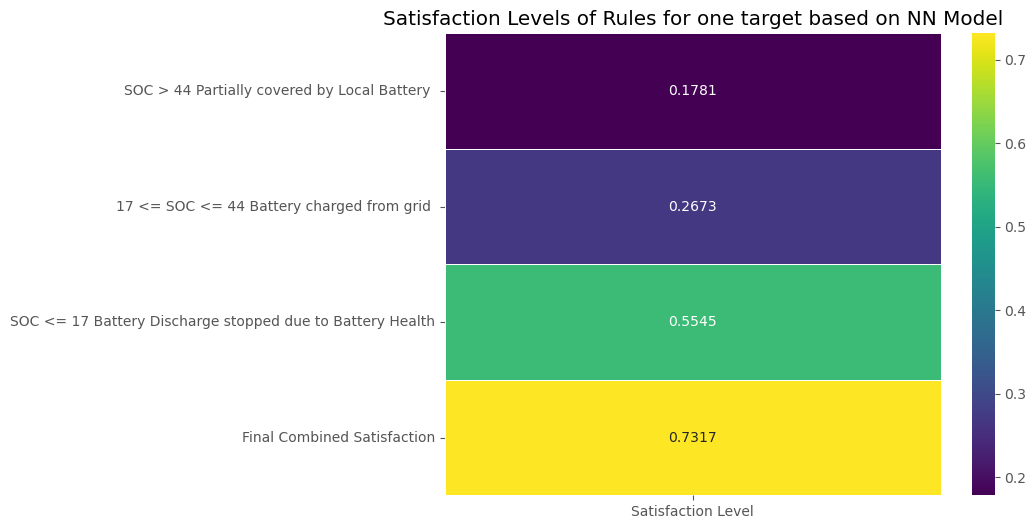

In [30]:
# Calculate satisfaction levels
satisfaction_levels = {
    "SOC > 44 Partially covered by Local Battery ": sat_rule1.item(),
    "17 <= SOC <= 44 Battery charged from grid ": sat_rule2.item(),
    "SOC <= 17 Battery Discharge stopped due to Battery Health": sat_rule3.item(),
    "Final Combined Satisfaction": satisfaction.item()
    
}
labels = list(satisfaction_levels.keys())
values = list(satisfaction_levels.values())
heatmap_data = pd.DataFrame(values, index=labels, columns=["Satisfaction Level"])
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap="viridis", linewidths=.5, fmt=".4f")
plt.title("Satisfaction Levels of Rules for one target based on NN Model") 
plt.show()

In [43]:
file_path = 'Stud_E-mobility_data_staticLimit.csv'
data = pd.read_csv(file_path)
data_info = data.info()
data_head = data.head()
data_description = data.describe()
(data_info, data_head, data_description)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59442 entries, 0 to 59441
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   _time                       59442 non-null  object 
 1   GARAGE_EXTERNAL_POWER       59442 non-null  float64
 2   DEMAND_LIMIT                59442 non-null  float64
 3   DEMAND_LIMIT_INDICATOR      59442 non-null  float64
 4   BATTERY_SOC                 59442 non-null  float64
 5   BATTERY_DISCHARGE_POWER     59442 non-null  float64
 6   BATTERY_CHARGED_ENERGY      59442 non-null  float64
 7   BATTERY_DISCHARGED_ENERGY   59442 non-null  float64
 8   PV_POWER                    59442 non-null  float64
 9   PV_ENERGY                   59442 non-null  float64
 10  WALLBOX_ALPHA_ENERGY        59442 non-null  float64
 11  WALLBOX_ALPHA_POWER         59442 non-null  float64
 12  WALLBOX_1_ENERGY            59442 non-null  float64
 13  WALLBOX_1_POWER             594

(None,
                        _time  GARAGE_EXTERNAL_POWER  DEMAND_LIMIT  \
 0  2023-10-05 00:01:00+00:00               1.244171          50.0   
 1  2023-10-05 00:02:00+00:00               1.244171          50.0   
 2  2023-10-05 00:03:00+00:00               1.244171          50.0   
 3  2023-10-05 00:04:00+00:00               1.244171          50.0   
 4  2023-10-05 00:05:00+00:00               1.244171          50.0   
 
    DEMAND_LIMIT_INDICATOR  BATTERY_SOC  BATTERY_DISCHARGE_POWER  \
 0                     1.0         40.5                   -0.338   
 1                     1.0         40.5                   -0.372   
 2                     1.0         40.5                   -0.393   
 3                     1.0         40.5                   -0.339   
 4                     1.0         40.5                   -0.371   
 
    BATTERY_CHARGED_ENERGY  BATTERY_DISCHARGED_ENERGY  PV_POWER  PV_ENERGY  \
 0                     0.0                        0.0  0.008693        0.0   
 1   

In [44]:
data.head(20)

,_time,GARAGE_EXTERNAL_POWER,DEMAND_LIMIT,DEMAND_LIMIT_INDICATOR,BATTERY_SOC,BATTERY_DISCHARGE_POWER,BATTERY_CHARGED_ENERGY,BATTERY_DISCHARGED_ENERGY,PV_POWER,PV_ENERGY,...,WALLBOX_3_ENERGY,WALLBOX_3_POWER,WALLBOX_A_ENERGY,WALLBOX_A_POWER,WALLBOX_B_ENERGY,WALLBOX_B_POWER,WALLBOX_C_ENERGY,WALLBOX_C_POWER,WALLBOX_FASTCHARGER_ENERGY,WALLBOX_FASTCHARGER_POWER
0,2023-10-05 00:01:00+00:00,1.244171,50.0,1.0,40.5,-0.338,0.000000,0.0,0.008693,0.0,...,0.000000,0.006914,0.000000,0.010233,0.000000,0.010435,0.000000,0.010112,0.000000,0.154965
1,2023-10-05 00:02:00+00:00,1.244171,50.0,1.0,40.5,-0.372,0.000000,0.0,0.008693,0.0,...,0.000000,0.007550,0.000977,0.010233,0.000000,0.010435,0.000000,0.010112,0.007812,0.155586
2,2023-10-05 00:03:00+00:00,1.244171,50.0,1.0,40.5,-0.393,0.000000,0.0,0.008693,0.0,...,0.000000,0.006996,0.000000,0.010233,0.000000,0.010435,0.000000,0.010112,0.000000,0.157340
3,2023-10-05 00:04:00+00:00,1.244171,50.0,1.0,40.5,-0.339,0.000000,0.0,0.008693,0.0,...,0.000000,0.007392,0.000000,0.010233,0.000977,0.010435,0.000000,0.010112,0.000000,0.158009
4,2023-10-05 00:05:00+00:00,1.244171,50.0,1.0,40.5,-0.371,0.000000,0.0,0.008693,0.0,...,0.000000,0.007188,0.000000,0.010233,0.000000,0.010435,0.000000,0.010112,0.007812,0.158804
5,2023-10-05 00:06:00+00:00,1.339874,50.0,1.0,40.5,-0.477,0.000000,0.0,0.008693,0.0,...,0.000000,0.007132,0.000000,0.010233,0.000000,0.010435,0.000000,0.010112,0.000000,0.158213
6,2023-10-05 00:07:00+00:00,1.339874,50.0,1.0,40.5,-0.373,0.000000,0.0,0.008693,0.0,...,0.000000,0.007680,0.000000,0.010233,0.000000,0.010435,0.000000,0.010112,0.000000,0.158075
7,2023-10-05 00:08:00+00:00,1.244171,50.0,1.0,40.5,-0.359,0.000000,0.0,0.008550,0.0,...,0.000977,0.006988,0.000977,0.010233,0.000000,0.010435,0.000000,0.010112,0.007812,0.156482
8,2023-10-05 00:09:00+00:00,1.244171,50.0,1.0,40.5,-0.339,0.000000,0.0,0.008550,0.0,...,0.000000,0.007089,0.000000,0.010233,0.000977,0.010435,0.000000,0.010112,0.000000,0.156322
9,2023-10-05 00:10:00+00:00,1.244171,50.0,1.0,40.5,-0.292,0.000000,0.0,0.008633,0.0,...,0.000000,0.007034,0.000000,0.010233,0.000000,0.010435,0.000000,0.010112,0.000000,0.157987


### Checking for random BATTERY_SOC values

In [45]:
subset = data[['BATTERY_SOC','GARAGE_EXTERNAL_POWER', 'DEMAND_LIMIT', 'BATTERY_DISCHARGE_POWER']].head(100)

In [46]:
subset.head()

,BATTERY_SOC,GARAGE_EXTERNAL_POWER,DEMAND_LIMIT,BATTERY_DISCHARGE_POWER
0,40.5,1.244171,50.0,-0.338
1,40.5,1.244171,50.0,-0.372
2,40.5,1.244171,50.0,-0.393
3,40.5,1.244171,50.0,-0.339
4,40.5,1.244171,50.0,-0.371


In [50]:
# Prepare the data
data = {
    'BATTERY_SOC': np.arange(0, 100),
    'GARAGE_EXTERNAL_POWER': subset['GARAGE_EXTERNAL_POWER'].values,
    'DEMAND_LIMIT': subset['DEMAND_LIMIT'].values,
    'BATTERY_DISCHARGE_POWER': subset['BATTERY_DISCHARGE_POWER'].values
}

# Convert the data into tensors
soc_tensor = torch.tensor(data['BATTERY_SOC'], dtype=torch.float32).unsqueeze(-1)
external_power_tensor = torch.tensor(data['GARAGE_EXTERNAL_POWER'], dtype=torch.float32).unsqueeze(-1)
demand_limit_tensor = torch.tensor(data['DEMAND_LIMIT'], dtype=torch.float32).unsqueeze(-1)
discharge_power_tensor = torch.tensor(data['BATTERY_DISCHARGE_POWER'], dtype=torch.float32).unsqueeze(-1)

# Convert tensors to LTN Variables
SOC = ltn.Variable('soc', soc_tensor)
GARAGE_EXTERNAL_POWER = ltn.Variable('external_power', external_power_tensor)
DEMAND_LIMIT = ltn.Variable('demand_limit', demand_limit_tensor)
BATTERY_DISCHARGE_POWER = ltn.Variable('discharge_power', discharge_power_tensor)

# Define the BatteryManagementModel class
class BatteryManagementModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(3, 10),
            nn.ReLU(),
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 3),  # Adjusted to output 3 values for 3 rules
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.layers(x)

model = BatteryManagementModel()

# Defining how the conditions function utilizes the model
def conditions(soc, external_power, demand_limit):
    inputs = torch.cat([soc.value, external_power.value, demand_limit.value], dim=1)
    return model(inputs)

# Define the LTN predicates using functions
def less_than_18(x):
    return x < 18

def between_18_and_44(x):
    return (x >= 18) * (x <= 44)

def greater_than_44(x):
    return x > 44

def garage_external_power_gt_demand_limit(x, y):
    return x > y

def garage_external_power_lt_demand_limit(x, y):
    return x < y
# Instantiate predicates
SOC_lt_18 = ltn.Predicate(func=less_than_18)
SOC_between_18_and_44 = ltn.Predicate(func=between_18_and_44)
SOC_gt_44 = ltn.Predicate(func=greater_than_44)
GARAGE_EXTERNAL_POWER_gt_DEMAND_LIMIT = ltn.Predicate(func=garage_external_power_gt_demand_limit)
GARAGE_EXTERNAL_POWER_lt_DEMAND_LIMIT = ltn.Predicate(func=garage_external_power_lt_demand_limit)
# Define the logical rules as functions
def rule1():
    condition = SOC_gt_44(SOC).value
    return condition * conditions(SOC, GARAGE_EXTERNAL_POWER, DEMAND_LIMIT)[:, 2]

def rule2():
    condition = SOC_between_18_and_44(SOC).value * GARAGE_EXTERNAL_POWER_lt_DEMAND_LIMIT(GARAGE_EXTERNAL_POWER, DEMAND_LIMIT).value
    return condition

def rule3():
    condition = SOC_lt_18(SOC).value
    return condition * conditions(SOC, GARAGE_EXTERNAL_POWER, DEMAND_LIMIT)[:, 2]

# Define custom logical OR operation for combining axioms
def logical_or(*args):
    return 1 - torch.prod(1 - torch.stack(args))

def evaluate_rule(rule):
    return torch.mean(rule)

# Axioms combining the rules
def axioms():
    sat_rule1 = evaluate_rule(rule1())
    sat_rule2 = evaluate_rule(rule2())
    sat_rule3 = evaluate_rule(rule3())
    return logical_or(sat_rule1, sat_rule2, sat_rule3), sat_rule1, sat_rule2, sat_rule3

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
for epoch in range(1000):
    optimizer.zero_grad()
    satisfaction, sat_rule1, sat_rule2, sat_rule3 = axioms()
    loss = 1 - satisfaction
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}, Combined Satisfaction {satisfaction.item()}")
        print(f"Rule1 Satisfaction {sat_rule1.item()}, Rule2 Satisfaction {sat_rule2.item()}, Rule3 Satisfaction {sat_rule3.item()}")

print(f"Final Loss: {loss.item()}, Final Combined Satisfaction: {satisfaction.item()}")
print(f"Rule1 Satisfaction: {sat_rule1.item()}, Rule2 Satisfaction: {sat_rule2.item()}, Rule3 Satisfaction: {sat_rule3.item()}")



Epoch 0: Loss 0.6660275459289551, Combined Satisfaction 0.3339724540710449
Rule1 Satisfaction 0.04380636662244797, Rule2 Satisfaction 0.27000001072883606, Rule3 Satisfaction 0.04583502933382988
Epoch 10: Loss 0.34055042266845703, Combined Satisfaction 0.659449577331543
Rule1 Satisfaction 0.4715118408203125, Rule2 Satisfaction 0.27000001072883606, Rule3 Satisfaction 0.11727935820817947
Epoch 20: Loss 0.2800405025482178, Combined Satisfaction 0.7199594974517822
Rule1 Satisfaction 0.5448692440986633, Rule2 Satisfaction 0.27000001072883606, Rule3 Satisfaction 0.1571277678012848
Epoch 30: Loss 0.274122416973114, Combined Satisfaction 0.725877583026886
Rule1 Satisfaction 0.548723578453064, Rule2 Satisfaction 0.27000001072883606, Rule3 Satisfaction 0.16789332032203674
Epoch 40: Loss 0.27253198623657227, Combined Satisfaction 0.7274680137634277
Rule1 Satisfaction 0.5493707060813904, Rule2 Satisfaction 0.27000001072883606, Rule3 Satisfaction 0.1715330332517624
Epoch 50: Loss 0.2718684673309326,

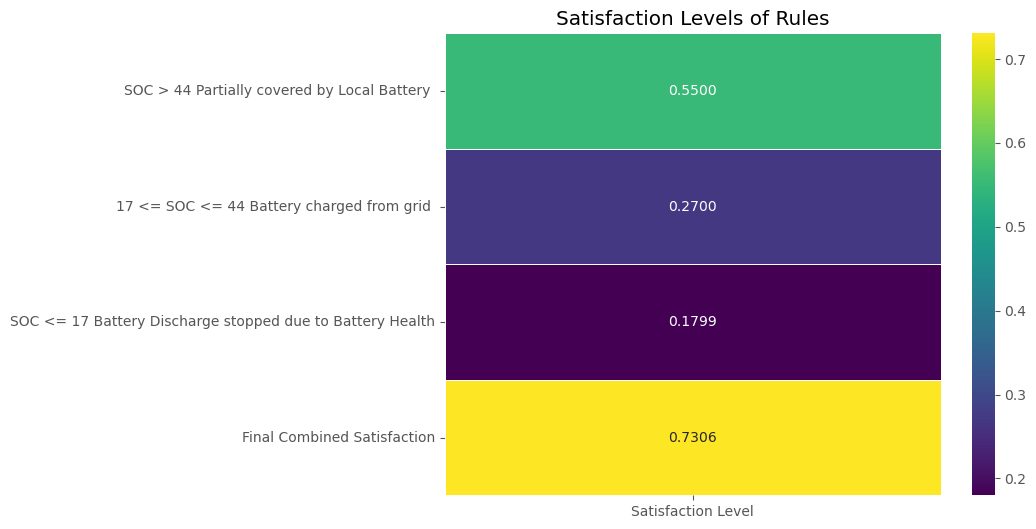

In [51]:
# Calculate satisfaction levels
satisfaction_levels = {
    "SOC > 44 Partially covered by Local Battery ": sat_rule1.item(),
    "17 <= SOC <= 44 Battery charged from grid ": sat_rule2.item(),
    "SOC <= 17 Battery Discharge stopped due to Battery Health": sat_rule3.item(),
    "Final Combined Satisfaction": satisfaction.item()
    
}
labels = list(satisfaction_levels.keys())
values = list(satisfaction_levels.values())
heatmap_data = pd.DataFrame(values, index=labels, columns=["Satisfaction Level"])
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap="viridis", linewidths=.5, fmt=".4f")
plt.title("Satisfaction Levels of Rules")
plt.show()

### Checking rules for 'BATTERY_SOC' and 'WALLBOX_FASTCHARGER_POWER' parameter combinations

In [84]:
# Prepare the data
data = {
    'BATTERY_SOC': np.arange(0, 100),
    'GARAGE_EXTERNAL_POWER': subset['GARAGE_EXTERNAL_POWER'].values,
    'DEMAND_LIMIT': subset['DEMAND_LIMIT'].values,
    'BATTERY_DISCHARGE_POWER': subset['BATTERY_DISCHARGE_POWER'].values,
    'WALLBOX_FASTCHARGER_POWER': np.arange(0, 100)
    
}

In [85]:


# Convert the data into tensors
soc_tensor = torch.tensor(data['BATTERY_SOC'], dtype=torch.float32).unsqueeze(-1)
external_power_tensor = torch.tensor(data['GARAGE_EXTERNAL_POWER'], dtype=torch.float32).unsqueeze(-1)
demand_limit_tensor = torch.tensor(data['DEMAND_LIMIT'], dtype=torch.float32).unsqueeze(-1)
discharge_power_tensor = torch.tensor(data['BATTERY_DISCHARGE_POWER'], dtype=torch.float32).unsqueeze(-1)
fastcharger_power_tensor = torch.tensor(data['WALLBOX_FASTCHARGER_POWER'], dtype=torch.float32).unsqueeze(-1)

# Convert tensors to LTN Variables
SOC = ltn.Variable('soc', soc_tensor)
GARAGE_EXTERNAL_POWER = ltn.Variable('external_power', external_power_tensor)
DEMAND_LIMIT = ltn.Variable('demand_limit', demand_limit_tensor)
BATTERY_DISCHARGE_POWER = ltn.Variable('discharge_power', discharge_power_tensor)
WALLBOX_FASTCHARGER_POWER = ltn.Variable('fastcharger_power', fastcharger_power_tensor)

# Define the BatteryManagementModel class
class BatteryManagementModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(4, 10),
            nn.ReLU(),
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 4),  # Adjusted to output 4 values for 4 rules
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.layers(x)

model = BatteryManagementModel()

# Defining how the conditions function utilizes the model
def conditions(soc, external_power, demand_limit, fastcharger_power):
    inputs = torch.cat([soc.value, external_power.value, demand_limit.value, fastcharger_power.value], dim=1)
    return model(inputs)

# Define the LTN predicates using functions
def less_than_17(x):
    return x < 17

def between_17_and_60(x):
    return (x >= 17) * (x < 60)

def greater_than_60(x):
    return x >= 60

def fastcharger_power_ge_75(x):
    return x >= 75

def fastcharger_power_ge_60(x):
    return x >= 60

def fastcharger_power_lt_40(x):
    return x < 40

# Instantiate predicates
SOC_lt_17 = ltn.Predicate(func=less_than_17)
SOC_between_17_and_60 = ltn.Predicate(func=between_17_and_60)
SOC_ge_60 = ltn.Predicate(func=greater_than_60)
FASTCHARGER_POWER_ge_75 = ltn.Predicate(func=fastcharger_power_ge_75)
FASTCHARGER_POWER_ge_60 = ltn.Predicate(func=fastcharger_power_ge_60)
FASTCHARGER_POWER_lt_40 = ltn.Predicate(func=fastcharger_power_lt_40)

# Define the logical rules as functions
def rule1():
    condition = FASTCHARGER_POWER_ge_75(WALLBOX_FASTCHARGER_POWER).value
    return condition * conditions(SOC, GARAGE_EXTERNAL_POWER, DEMAND_LIMIT, WALLBOX_FASTCHARGER_POWER)[:, 0]

def rule2():
    condition = SOC_ge_60(SOC).value * FASTCHARGER_POWER_ge_60(WALLBOX_FASTCHARGER_POWER).value
    return condition * conditions(SOC, GARAGE_EXTERNAL_POWER, DEMAND_LIMIT, WALLBOX_FASTCHARGER_POWER)[:, 1]

def rule3():
    condition = SOC_between_17_and_60(SOC).value * FASTCHARGER_POWER_lt_40(WALLBOX_FASTCHARGER_POWER).value
    return condition * conditions(SOC, GARAGE_EXTERNAL_POWER, DEMAND_LIMIT, WALLBOX_FASTCHARGER_POWER)[:, 2]

def rule4():
    condition = SOC_lt_17(SOC).value * FASTCHARGER_POWER_lt_40(WALLBOX_FASTCHARGER_POWER).value
    return condition * conditions(SOC, GARAGE_EXTERNAL_POWER, DEMAND_LIMIT, WALLBOX_FASTCHARGER_POWER)[:, 3]

# Define custom logical OR operation for combining axioms
def logical_or(*args):
    return 1 - torch.prod(1 - torch.stack(args))

def evaluate_rule(rule):
    return torch.mean(rule)
# Axioms combining the rules
def axioms():
    sat_rule1 = evaluate_rule(rule1())
    sat_rule2 = evaluate_rule(rule2())
    sat_rule3 = evaluate_rule(rule3())
    sat_rule4 = evaluate_rule(rule4())
    return logical_or(sat_rule1, sat_rule2, sat_rule3, sat_rule4), sat_rule1, sat_rule2, sat_rule3, sat_rule4

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
for epoch in range(1000):
    optimizer.zero_grad()
    satisfaction, sat_rule1, sat_rule2, sat_rule3, sat_rule4 = axioms()
    loss = 1 - satisfaction
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}, Combined Satisfaction {satisfaction.item()}")
        print(f"Rule1 Satisfaction {sat_rule1.item()}, Rule2 Satisfaction {sat_rule2.item()}, Rule3 Satisfaction {sat_rule3.item()}, Rule4 Satisfaction {sat_rule4.item()}")

print(f"Final Loss: {loss.item()}, Final Combined Satisfaction: {satisfaction.item()}")
print(f"Rule1 Satisfaction: {sat_rule1.item()}, Rule2 Satisfaction: {sat_rule2.item()}, Rule3 Satisfaction: {sat_rule3.item()},, Rule4 Satisfaction: {sat_rule4.item()}")

Epoch 0: Loss 0.4766697883605957, Combined Satisfaction 0.5233302116394043
Rule1 Satisfaction 0.20768582820892334, Rule2 Satisfaction 0.06491480022668839, Rule3 Satisfaction 0.22546811401844025, Rule4 Satisfaction 0.1693277209997177
Epoch 10: Loss 0.3681596517562866, Combined Satisfaction 0.6318403482437134
Rule1 Satisfaction 0.24296817183494568, Rule2 Satisfaction 0.2402835339307785, Rule3 Satisfaction 0.22895266115665436, Rule4 Satisfaction 0.16978707909584045
Epoch 20: Loss 0.3002965450286865, Combined Satisfaction 0.6997034549713135
Rule1 Satisfaction 0.247378408908844, Rule2 Satisfaction 0.3759997487068176, Rule3 Satisfaction 0.2296941727399826, Rule4 Satisfaction 0.16990885138511658
Epoch 30: Loss 0.2903099060058594, Combined Satisfaction 0.7096900939941406
Rule1 Satisfaction 0.24873264133930206, Rule2 Satisfaction 0.39549410343170166, Rule3 Satisfaction 0.2298714518547058, Rule4 Satisfaction 0.16995136439800262
Epoch 40: Loss 0.28873980045318604, Combined Satisfaction 0.71126019

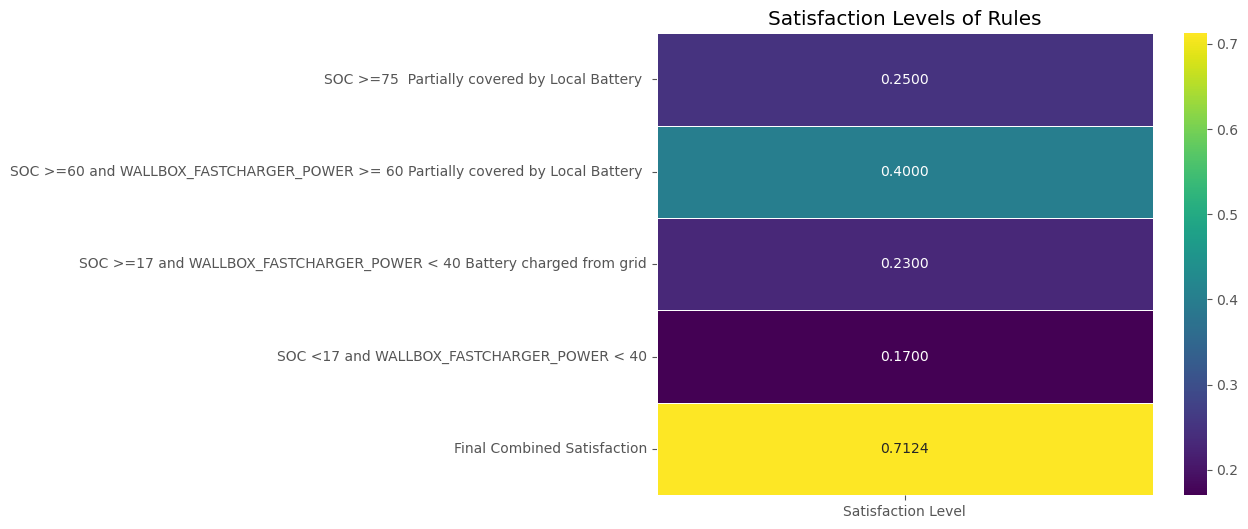

In [86]:
# Calculate satisfaction levels
satisfaction_levels = {
    "SOC >=75  Partially covered by Local Battery ": sat_rule1.item(),
    "SOC >=60 and WALLBOX_FASTCHARGER_POWER >= 60 Partially covered by Local Battery ": sat_rule2.item(),
    "SOC >=17 and WALLBOX_FASTCHARGER_POWER < 40 Battery charged from grid": sat_rule3.item(),
    "SOC <17 and WALLBOX_FASTCHARGER_POWER < 40": sat_rule4.item(),
    "Final Combined Satisfaction": satisfaction.item()
    
}
labels = list(satisfaction_levels.keys())
values = list(satisfaction_levels.values())
heatmap_data = pd.DataFrame(values, index=labels, columns=["Satisfaction Level"])
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap="viridis", linewidths=.5, fmt=".4f")
plt.title("Satisfaction Levels of Rules")
plt.show()